<a href="https://colab.research.google.com/github/ElvisRojasM/Construction-of-Socioeconomic-Indicators-Using-Python/blob/main/3_Indicadores_de_salud_infantil_ENDES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indicadores de salud infantil - ENDES - INEI



En este proyecto se recopila y análiza los datos de encuestas anuales - ENDES, utilizando información detallada de características del hogar, características de la vivienda y datos de peso y talla de los encuestados.

1. **Carga y Preprocesamiento de Datos**:
   - Descarga y lectura de archivos de datos SPSS desde fuentes INEI para diferentes módulos.
   - Renombrado y unificación de columnas para consistencia.
   - Unión de datos de diferentes módulos basándose en identificadores comunes.

2. **Creación de Variables de Estudio**:
   - **Desnutrición Crónica Infantil**: Definida por la altura para la edad, clasificada en 'DC' (Desnutrición Crónica) y 'No DC'.
   - **Anemia Infantil**: Basada en los niveles de hemoglobina y edad de los niños, clasificada en 'Anemia' y 'No Anemia'.

3. **Cálculo de Tasas Ponderadas**:
   - Uso de pesos muestrales para calcular tasas ponderadas de desnutrición y anemia infantil.
   - Agregación de resultados a nivel de región y departamento, proporcionando una visión geográfica de estos indicadores.

4. **Ebaloración de reportes**


In [ ]:


import pandas as pd
import numpy as np
import requests
from zipfile import ZipFile
from io import BytesIO

import matplotlib.pyplot as plt

from functools import partial, reduce
import time
import requests
from io import StringIO

from google.colab import drive

import scipy.stats as st
import matplotlib.gridspec as gridspec



In [ ]:
pip install pyreadstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.9 MB/s eta 0:00:00


In [ ]:
pip install geopandas

In [ ]:
def get_data_inei(zip_url,identifiers):

  r         = requests.get(zip_url)
  z         = ZipFile(BytesIO(r.content))
  zipflies  = z.namelist()
  substr    = ['.SAV', '.sav']
  data_files  =[]
  for i in substr:
    for j in zipflies:
      if(j.find(i)!=-1 and j not in data_files):
        data_files.append(j)

  print('=====================================================================')
  [print(f'"{a}"') for a in data_files]
  print('=====================================================================')

  filtered_files = [ifile for ifile in data_files if any(ident == ifile.split('/')[-1].split('.')[0] for ident in identifiers)]

  rad    = {};   df_all = {}

  kk = 0
  for ii in filtered_files:
    print(f"In {kk+1}, we use {ii}, its name is {identifiers[kk]}")
    df_all[identifiers[kk]]  = pd.read_spss(z.extract(ii))
    kk +=1

  print("\n \n")
  return df_all

In [ ]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 3.7 MB/s eta 0:00:00


In [ ]:
from unidecode import unidecode

def remove_accents(text):
    return unidecode(text)


In [ ]:
def rate_cat(df, var, peso, year):

    categorias        = df[var].value_counts().index
    total_poblacion   = df[peso].sum()
    rate_Store        = []

    for ii in categorias:

        datos_categoria = df[df[var] == ii]
        ## promedio ponderada
        var_ponderada   = (datos_categoria[peso] * (datos_categoria[var] == ii)).sum()
        tasa_ponderada  = var_ponderada / total_poblacion
        ## guardar resultado
        rate_Store.append( (ii, tasa_ponderada) )

    df_tasas = pd.DataFrame(rate_Store, columns=['Categoría', 'Tasa ponderada'])
    df_tasas['year'] = year
    return df_tasas

In [ ]:
def weighted_mean(df, col, by, wt, year, frequency=False):

    '''
    df : dataframe;
    col : column for which you want statistics, must be single column;
    by : groupby column(s)
    wt : column to use for weights;
    frequency : if True, use sample size as sum of weights (only effects degrees of freedom correction for unbiased variance)
    '''

    if isinstance(by, list):
        df = df.sort_values(by + [col])
    else:
        df = df.sort_values([by] + [col])

    newcols = ['gb_weights', 'col_weighted', 'gb_weights_cumsum', 'ngroup']
    assert all([c not in df.columns for c in newcols])

    gb_weights              = df[wt] / df.groupby(by)[wt].transform('sum')
    df['gb_weights']        = gb_weights

    df['gb_weights_cumsum'] = df.groupby(by)['gb_weights'].cumsum()

    df['col_weighted']      = df.eval('{} * gb_weights'.format(col))

    wmean        = df.groupby(by)['col_weighted'].sum()
    wmean.name   = col
    wmean.reset_index()

    out = pd.DataFrame(wmean)
    out['year'] = year
    return   out



In [ ]:
## Stores dataframes raw
df_modulo64 = {}; df_modulo65 = {}; df_modulo74 = {}

store_cols = {}

#survey_codes = [ 194 , 209, 238, 260, 290, 323, 407, 441,	504, 548, 605, 638, 691, 739, 760]
#year         = 2007;

survey_codes  = [323, 407, 441,	504, 548, 605, 638, 691, 739, 760, 786]


iyear          = 2012;
DC_Store        = [] ; Anemia_Store = []; ane_dep_Store_map = []; desn_dep_Store_map = []
Store_regi_desn = []; Store_regi_anem = []


################# MEAN LOOP ###############

for srvcs in survey_codes:
  print('=====================================================================')
  print(f'============= year {iyear} and survey code {srvcs} ==================' )
  print('=====================================================================\n\n')
  if srvcs <= 691: #a partir del ano 2020, los codigos de los modulos cambian, por ejemplo el que antes se llamaba 64, ahora es 1629
    zip_url_modulo64   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo64.zip' #Caracteristicas del Hogar
    zip_url_modulo65   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo65.zip' #Caracteristicas de la Vivienda
    zip_url_modulo74   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo74.zip' #Peso y talla - Anemia

  else: ## after 2020, codes change
    zip_url_modulo64   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo1629.zip' #Caracteristicas del Hogar
    zip_url_modulo65   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo1630.zip' #Caracteristicas de la Vivienda
    zip_url_modulo74   = 'https://proyectos.inei.gob.pe/iinei/srienaho/descarga/SPSS/' + str(srvcs) + '-Modulo1638.zip' #Peso y talla - Anemia

  print('========================= MODULO 64 ====================================')
  df_modulo64 = get_data_inei(zip_url_modulo64,['RECH0','RECH1','RECH4'])
  print('========================= MODULO 65 ====================================')
  df_modulo65 = get_data_inei(zip_url_modulo65,['RECH23'])
  print('========================= MODULO 74 ====================================')
  df_modulo74 = get_data_inei(zip_url_modulo74,['RECH6'])

  ## modulo 64, archivo rech0
  rech0 = df_modulo64['RECH0']
  ## para ciertos anos, el "peso del hogares" esta registrado en minuscula o mezclado
  rech0.columns = rech0.columns.str.upper()
  ## modulo 64, archivo rech1
  rech1 = df_modulo64['RECH1']
  # en rech1 : rename HVIDX HC0
  rech1.rename({'HVIDX':'HC0'},axis='columns', inplace=True) #old, new
  ## modulo 64, archivo rech4
  rech4 = df_modulo64['RECH4']
  # en rech4 rename IDXH4 HC0
  rech4.rename({'IDXH4':'HC0'},axis='columns', inplace=True) #old, new
  ## modulo 65, archivo rech23
  rech23 = df_modulo65['RECH23']
  ## modulo 74, archivo rech6
  rech6 = df_modulo74['RECH6']


  ## Primero: unir rech0 y rech23
  merged_1 = pd.merge(rech0,rech23, how='inner', on='HHID')
  ## Segundo unir rech1 , rech4 y rech6
  merged_2 = reduce(lambda left, right: pd.merge(left, right, on=['HHID','HC0'], how='inner'), [rech1, rech4, rech6])
  ## Tercero:   merged_2 y merged_1
  merged_3 = pd.merge(merged_2, merged_1, on='HHID', validate='many_to_one' )

  print(f"la dimension de merged_3 es {merged_3.shape}")

  ##############################################################################

  ##crear la variable ambito en base a "SHREGION"
  merged_3['SHREGION'] = merged_3['SHREGION'].str.lower().str.normalize("NFD").str.split().str[0]

  ## escalamaos la variable de pesos, el cual proviene de rech0
  merged_3['weight'] =  merged_3['HV005']/1000000

  ## uniformizar la "permanencia del entrevistado" en HV103
  merged_3['HV103'] = merged_3['HV103'].apply(remove_accents) #eliminar el acento
  merged_3['HV103'] = merged_3['HV103'].str.lower().str.lstrip() # minisculas y eliminar espacios en blanco

  # Convertir la columna 'HC70'(altura por edad) de categorica a cadena de texto
  merged_3['HC70']  = merged_3['HC70'].astype(str)
  merged_3['HC70']  = pd.to_numeric(merged_3['HC70'], errors='coerce')

  ##############################################################################
  ################## Creando la desnutricion infantil cronica #################
  ##############################################################################
  # Definir las condiciones, los valores y aplicar las condiciones para crear la desnutricion
  condiciones = [
      (merged_3['HC70'] < -200) & ( (merged_3['HV103'] == 'si') | (merged_3['HV103'] == 'yes') ),
      (merged_3['HC70'] >= -200) & (merged_3['HC70'] < 601)  & ( (merged_3['HV103'] == 'si') | (merged_3['HV103'] == 'yes') ) ]
  valores             = ['DC', 'No DC']
  merged_3['desnwho'] = np.select(condiciones, valores, default=np.nan)

  ##############################################################################
  ################## Creando la tasa de anemia infantil  #################
  ##############################################################################

  merged_3['HC1']  = pd.to_numeric(merged_3['HC1'], errors='coerce') # edad
  merged_3['HC56'] = pd.to_numeric(merged_3['HC56'], errors='coerce') # nivel de hemoglobina

  conditions = [
      ((merged_3['HV103'] == 'si') | (merged_3['HV103'] == 'yes')) & ((merged_3['HC1'] > 5) & (merged_3['HC1'] < 36)) & (merged_3['HC56'] >= 110),
      ((merged_3['HV103'] == 'si') | (merged_3['HV103'] == 'yes')) & ((merged_3['HC1'] > 5) & (merged_3['HC1'] < 36)) & (merged_3['HC56'] < 110) ]

  choices = ['No Anemia', 'Anemia']
  merged_3['anem'] = np.select(conditions, choices, default=np.nan)

  ## calculamoos la tasas ponderada de desnutricion y anemia infantil:

  res         = rate_cat(merged_3[merged_3.desnwho != 'nan'], 'desnwho', 'weight', iyear)
  res         = res.pivot(index='year', columns="Categoría", values="Tasa ponderada").reset_index() ## darle un formato al resultado
  DC_Store.append(res)

  #la tasa de anemia
  anemi       = rate_cat(merged_3[merged_3.anem != 'nan'], 'anem', 'weight', iyear)
  anemi       = anemi.pivot(index = 'year', columns = "Categoría", values="Tasa ponderada").reset_index()
  Anemia_Store.append(anemi)

  ## Calcular la anemia por diferentes tipos de categorias: Areas, departamentos, etc.

  merged_3['anem_bin'] = merged_3['anem'].apply(lambda x: 1 if x == 'Anemia' else (0 if x == 'No Anemia' else np.nan))
  merged_3['desn_bin'] = merged_3['desnwho'].apply(lambda x: 1 if x == 'DC' else (0 if x == 'No DC' else np.nan))

  Store_regi_anem.append( weighted_mean(merged_3[merged_3.anem    != 'nan'],  'anem_bin', 'SHREGION', 'weight', year=iyear ) )
  Store_regi_desn.append( weighted_mean(merged_3[merged_3.desnwho != 'nan'],  'desn_bin', 'SHREGION', 'weight', year=iyear ))


  ## Anemia por departamentos :
  if 'UBIGEO' in merged_3.columns:
    merged_3['ID_DEP']  = [x[0:2]  for x in merged_3['UBIGEO'] ]
    ane_dep_Store_map.append(  weighted_mean(merged_3[merged_3.anem    != 'nan'], 'anem_bin', 'ID_DEP', 'weight', year=iyear ))
    desn_dep_Store_map.append( weighted_mean(merged_3[merged_3.desnwho != 'nan'], 'desn_bin', 'ID_DEP', 'weight', year=iyear))


  print("\n \n")


  iyear += 1



============= year 2012 and survey code 323 ==================


========================= MODULO 64 ====================================
"323-Modulo64/RECH9.SAV"
"323-Modulo64/RECH0.sav"
"323-Modulo64/RECH1.sav"
"323-Modulo64/RECH10.sav"
"323-Modulo64/RECH11.sav"
"323-Modulo64/RECH4.sav"
"323-Modulo64/RECH8.sav"
In 1, we use 323-Modulo64/RECH0.sav, its name is RECH0
In 2, we use 323-Modulo64/RECH1.sav, its name is RECH1
In 3, we use 323-Modulo64/RECH4.sav, its name is RECH4

 

========================= MODULO 65 ====================================
"323-Modulo65/RECH23.sav"
In 1, we use 323-Modulo65/RECH23.sav, its name is RECH23

 

========================= MODULO 74 ====================================
"323-Modulo74/REC44.sav"
"323-Modulo74/RECH5.sav"
"323-Modulo74/RECH6.sav"
In 1, we use 323-Modulo74/RECH6.sav, its name is RECH6

 

la dimension de merged_3 es (10231, 274)
Index(['No DC', 'DC'], dtype='object')
No DC
(7673, 277)
DC
(1989, 277)
Index(['No Anemia', 'Anemia'], dtype

In [ ]:
anemia  = pd.concat(Anemia_Store).loc[:,['year','Anemia']].set_index('year')*100
anemia

Categoría,Anemia
year,
2012,43.653231
2013,45.734053
2014,46.084173
2015,42.652408
2016,43.025565
2017,43.000559
2018,43.545012
2019,40.062234
2020,38.293454


In [ ]:
desnut  = pd.concat(DC_Store).loc[:,['year','DC']].set_index('year')*100
desnut

Categoría,DC
year,
2012,18.118744
2013,17.488197
2014,14.558530
2015,14.252997
2016,13.126524
2017,12.884419
2018,12.235996
2019,12.236047
2020,11.325635


In [ ]:
import geopandas as gpd
#url_mun  = "https://raw.githubusercontent.com/juaneladio/peru-geojson/master/peru_distrital_simple.geojson"
#mapa_coordinates_mun = gpd.read_file(url_mun)

url_dep  = "https://raw.githubusercontent.com/juaneladio/peru-geojson/master/peru_departamental_simple.geojson"
mapa_coordinates_dep = gpd.read_file(url_dep)
# Reproyectar las geometrías a un CRS proyectado
mapa_coordinates_dep = mapa_coordinates_dep.to_crs('EPSG:3395')  # Ejemplo de CRS proyectado, puedes cambiarlo según tus necesidades


In [ ]:
### a map with 6 columns and 3 rows:
map_desn = pd.concat(desn_dep_Store_map,axis=0)
map_desn['desn_bin'] = map_desn['desn_bin']*100


In [ ]:
### a map with 6 columns and 3 rows:
map_anem = pd.concat(ane_dep_Store_map,axis=0)
map_anem['anem_bin'] = map_anem['anem_bin']*100


In [ ]:
## Unir los datos de anemia y desnutrcion en un solo dataframe
map_resul = pd.merge(map_desn,map_anem, how='inner', on=['ID_DEP','year'] )

In [ ]:
### unir los datos con los datos para el mapa a nivel de departamentos
map_dep  = pd.merge(mapa_coordinates_dep, map_resul, how='inner', right_on='ID_DEP',left_on='FIRST_IDDP')


In [ ]:
pip install adjustText

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon
import random

## Tasa de anemia por departamentos entre el 2021 y 2022

0-1-

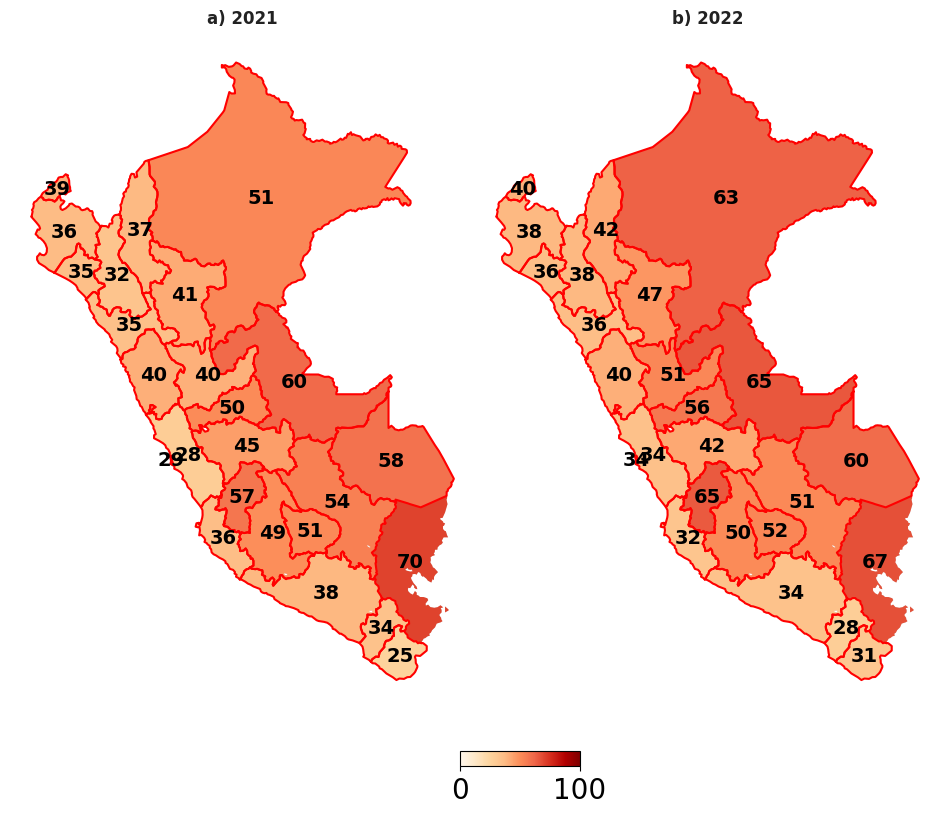

In [ ]:
map_dep_2years = map_dep[map_dep.year > 2020]

num_year = list(map_dep_2years.year.value_counts().index)
items = [chr(value) for value in range(97, 97+len(num_year))]
iyear = 2021

# Definir el tamaño de la figura y la estructura de la cuadrícula
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Crear una lista de mapas de colores para cada año
cmaps = [plt.cm.OrRd for _ in range(len(num_year))]

for ii in range(len(num_year)):
    print(ii, end='-')
    ax = fig.add_subplot(gs[0, ii])  # Obtener el subplot correspondiente a la posición actual
    df_year = map_dep_2years[map_dep_2years.year == iyear]
    mapa_coordinates_dep.plot(ax=ax, alpha=0.35, color="grey")
    df_year.plot(column='anem_bin', categorical=False, vmin=0, vmax=100, ax=ax, cmap=cmaps[ii],
                 legend=False)

    # Reproyectar las geometrías de los departamentos a un CRS proyectado
    df_year = df_year.to_crs('EPSG:3395')  # Reemplaza 'EPSG:3395' con el CRS proyectado que desees

    # Agregar etiquetas a cada polígono con desplazamiento aleatorio
    for x, y, label in zip(df_year.geometry.centroid.x, df_year.geometry.centroid.y, df_year['anem_bin']):
        x_offset = random.uniform(-10, 2)  # Desplazamiento aleatorio en el eje x
        y_offset = random.uniform(-10, 2)  # Desplazamiento aleatorio en el eje y
        ax.text(x + x_offset, y + y_offset, int(label), fontsize=14, ha='center', va='center', color='black', fontweight='bold')

    # Delimitar el área de los departamentos con color rojo
    for geometry in df_year.geometry:
        if isinstance(geometry, Polygon):
            x, y = geometry.exterior.xy
            ax.plot(x, y, color='red', linewidth=1.5)

    ax.axis('off')
    ax.set_title(items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

    iyear += 1

mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.OrRd)
# define position and extent of colorbar
cb_ax = fig.add_axes([0.5, 0.1, 0.1, 0.015]) # The dimensions (left, bottom, width, height) of the new Axes
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal', pad=0.02)
# Cambiar el tamaño de fuente de las etiquetas del colorbar (puedes ajustar el tamaño según tus preferencias)
cbar.ax.tick_params(labelsize=20)
# Cambiar el tamaño de fuente del título del colorbar (puedes ajustar el tamaño según tus preferencias)
cbar.ax.set_title(' ', fontsize=18)
# Ajustar el tamaño del colorbar en sí (puedes ajustar el tamaño según tus preferencias)
cbar.ax.yaxis.set_tick_params( width = 2, length = 18 )

# Ajustar el tamaño de cada subplot
gs.update(wspace=0, hspace=0)

#ig.savefig("pobreza_deps_anios.pdf", bbox_inches='tight',transparent=True)
fig.savefig("anemia_deps_anios.png", bbox_inches='tight',transparent=True)

plt.show()


In [ ]:
df_year.reset_index(drop=True).sort_values(by="anem_bin", ascending=False).loc[:,['NOMBDEP','anem_bin']].head(3)

,NOMBDEP,anem_bin
20,PUNO,67.247499
24,UCAYALI,65.752418
8,HUANCAVELICA,65.036896


In [ ]:
df_year.reset_index(drop=True).sort_values(by="anem_bin", ascending=False).loc[:,['NOMBDEP','anem_bin']].tail(3)

,NOMBDEP,anem_bin
10,ICA,32.688504
22,TACNA,31.313301
17,MOQUEGUA,28.478143


## Tasa de desnutricion cronica por departamentos entre el 2021 y 2022

0-1-

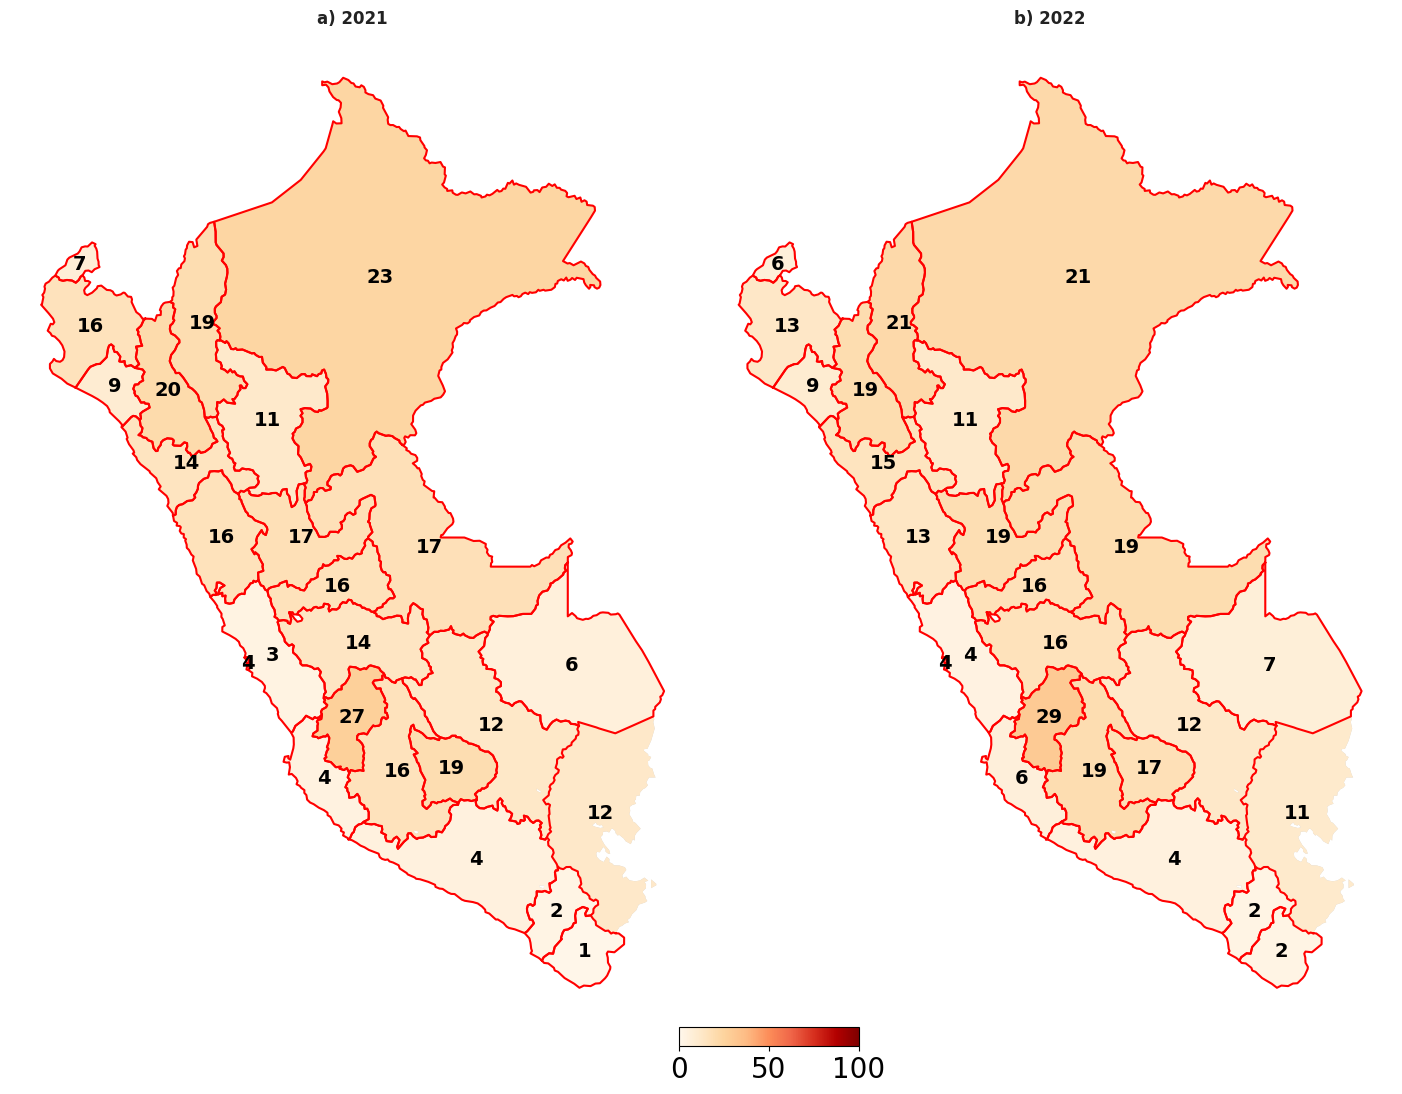

In [ ]:
map_dep_2years = map_dep[map_dep.year > 2020]

num_year = list(map_dep_2years.year.value_counts().index)

items = [chr(value) for value in range(97, 97+len(num_year))]
iyear = 2021

# Definir el tamaño de la figura y la estructura de la cuadrícula
fig = plt.figure(figsize=(18, 13))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Crear una lista de mapas de colores para cada año
cmaps = [plt.cm.OrRd for _ in range(len(num_year))]

for ii in range(len(num_year)):
    print(ii, end='-')
    ax = fig.add_subplot(gs[0, ii])  # Obtener el subplot correspondiente a la posición actual
    df_year = map_dep_2years[map_dep_2years.year == iyear]
    mapa_coordinates_dep.plot(ax=ax, alpha=0.35, color="grey")
    df_year.plot(column='desn_bin', categorical=False, vmin=0, vmax=100, ax=ax, cmap=cmaps[ii],
                 legend=False)

    # Reproyectar las geometrías de los departamentos a un CRS proyectado
    df_year = df_year.to_crs('EPSG:3395')  # Reemplaza 'EPSG:3395' con el CRS proyectado que desees

    # Agregar etiquetas a cada polígono con desplazamiento aleatorio
    for x, y, label in zip(df_year.geometry.centroid.x, df_year.geometry.centroid.y, df_year['desn_bin']):
        x_offset = random.uniform(-10, 2)  # Desplazamiento aleatorio en el eje x
        y_offset = random.uniform(-10, 2)  # Desplazamiento aleatorio en el eje y
        ax.text(x + x_offset, y + y_offset, int(label), fontsize=14, ha='center', va='center', color='black', fontweight='bold')

    # Delimitar el área de los departamentos con color rojo
    for geometry in df_year.geometry:
        if isinstance(geometry, Polygon):
            x, y = geometry.exterior.xy
            ax.plot(x, y, color='red', linewidth=1.5)

    ax.axis('off')
    ax.set_title(items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

    iyear += 1

mappable = cm.ScalarMappable(norm=mcolors.Normalize(0,100), cmap=plt.cm.OrRd)
# define position and extent of colorbar
cb_ax = fig.add_axes([0.5, 0.1, 0.1, 0.015]) # The dimensions (left, bottom, width, height) of the new Axes
cbar = fig.colorbar(mappable, cax=cb_ax, orientation='horizontal', pad=0.02)
# Cambiar el tamaño de fuente de las etiquetas del colorbar (puedes ajustar el tamaño según tus preferencias)
cbar.ax.tick_params(labelsize=20)
# Cambiar el tamaño de fuente del título del colorbar (puedes ajustar el tamaño según tus preferencias)
cbar.ax.set_title(' ', fontsize=18)
# Ajustar el tamaño del colorbar en sí (puedes ajustar el tamaño según tus preferencias)
cbar.ax.yaxis.set_tick_params( width = 2, length = 18 )


# Ajustar el tamaño de cada subplot
gs.update(wspace=0, hspace=0)

#ig.savefig("pobreza_deps_anios.pdf", bbox_inches='tight',transparent=True)
fig.savefig("desn_deps_anios.png", bbox_inches='tight',transparent=True)

plt.show()


In [ ]:
df_year.reset_index(drop=True).sort_values(by="desn_bin", ascending=False).loc[:,['NOMBDEP','desn_bin']].round(0).head(3)

,NOMBDEP,desn_bin
8,HUANCAVELICA,30.0
15,LORETO,22.0
0,AMAZONAS,22.0


## Tasa de anemia a nivel nacional

In [ ]:

import matplotlib.dates as mdates   #v 3.3.2  ###


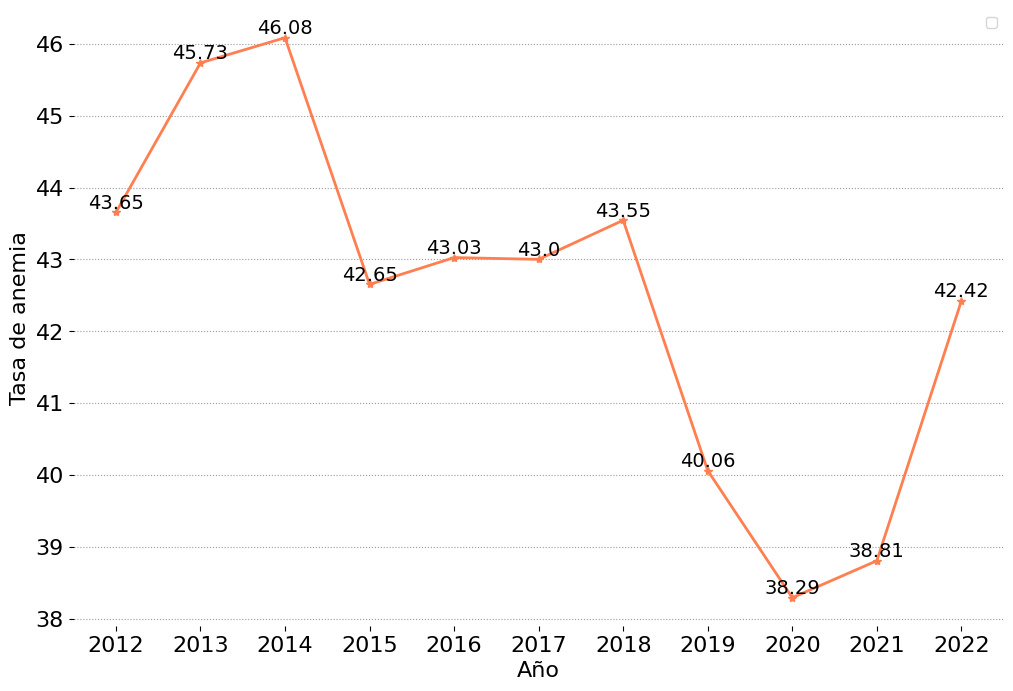

In [ ]:
fig, ax1 = plt.subplots(1,1,figsize=(12,8))

ax1.plot(anemia.Anemia, linewidth = 2, color = '#FF7F50', marker='*' )
ax1.grid(linestyle=':',alpha=0.8, color='gray',axis='y')


for x, y in zip(anemia.index, anemia.Anemia):
    plt.text(x, y, round(y,2), fontsize=14, ha='center', va='bottom')

legend = ax1.legend(loc='best')
legend.get_frame().set_alpha(0.5)

ftsz = 16
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

for ii in ['right', 'top', 'left','bottom' ]:
  ax1.spines[ii].set_visible(False)

ax1.set_ylabel("Tasa de anemia")
ax1.set_xlabel("Año")

years = 1
ax1.set_xticks(anemia.index[::years])

fig.savefig("anemia_anios.png", bbox_inches='tight',transparent=True)

plt.show()

## TAsa de desnutricion cronica a nivel nacional

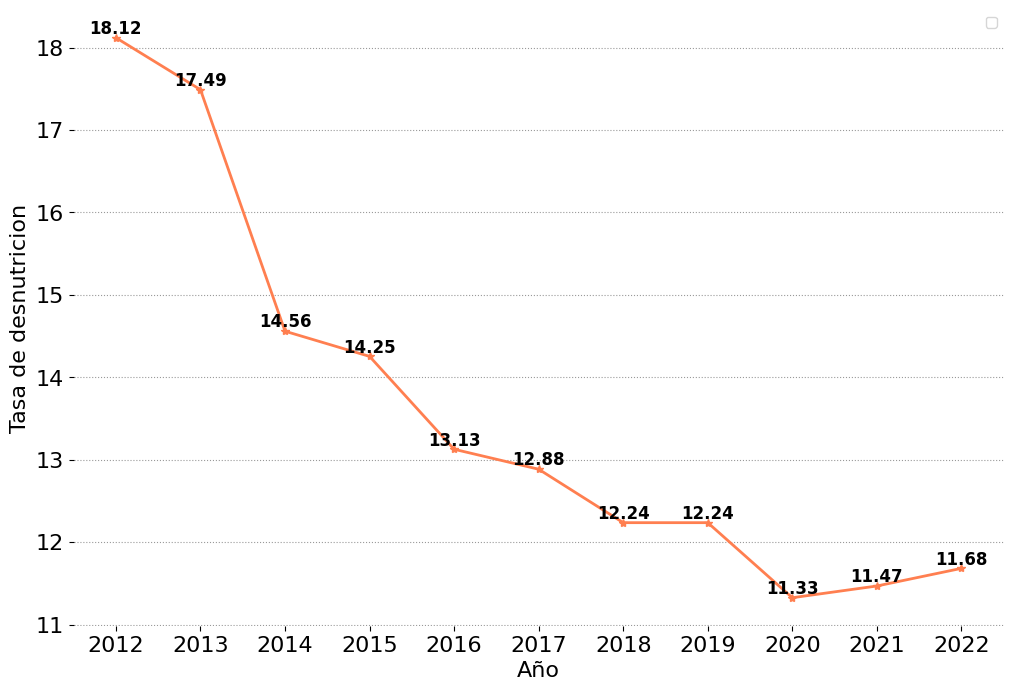

In [ ]:

fig,ax1 = plt.subplots(1,figsize=(12,8))

ax1.plot(desnut.DC, linewidth = 2, color = '#FF7F50', marker='*' )
ax1.grid(linestyle=':',alpha=0.8, color='gray',axis='y')

for x, y in zip(desnut.index, desnut.DC):
    plt.text(x, y, round(y,2), ha='center', va='bottom', fontsize=12, fontweight='bold')

legend = ax1.legend(loc='best')
legend.get_frame().set_alpha(0.5)

ftsz = 16
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

for ii in ['right', 'top', 'left','bottom' ]:
  ax1.spines[ii].set_visible(False)

ax1.set_ylabel("Tasa de desnutricion")
ax1.set_xlabel("Año")

years = 1
ax1.set_xticks(anemia.index[::years])
fig.savefig("desnut_anios.png", bbox_inches='tight',transparent=True)
plt.show()


### Hacer un grafico de costa, sierra y selva.
## Tambien mostrar la tasa a nivel nacional.

## Tasa de desnutricion cronica por region

In [ ]:
region = pd.concat(Store_regi_desn,axis=0).reset_index().set_index('year')
region['desn_bin'] = region['desn_bin']*100

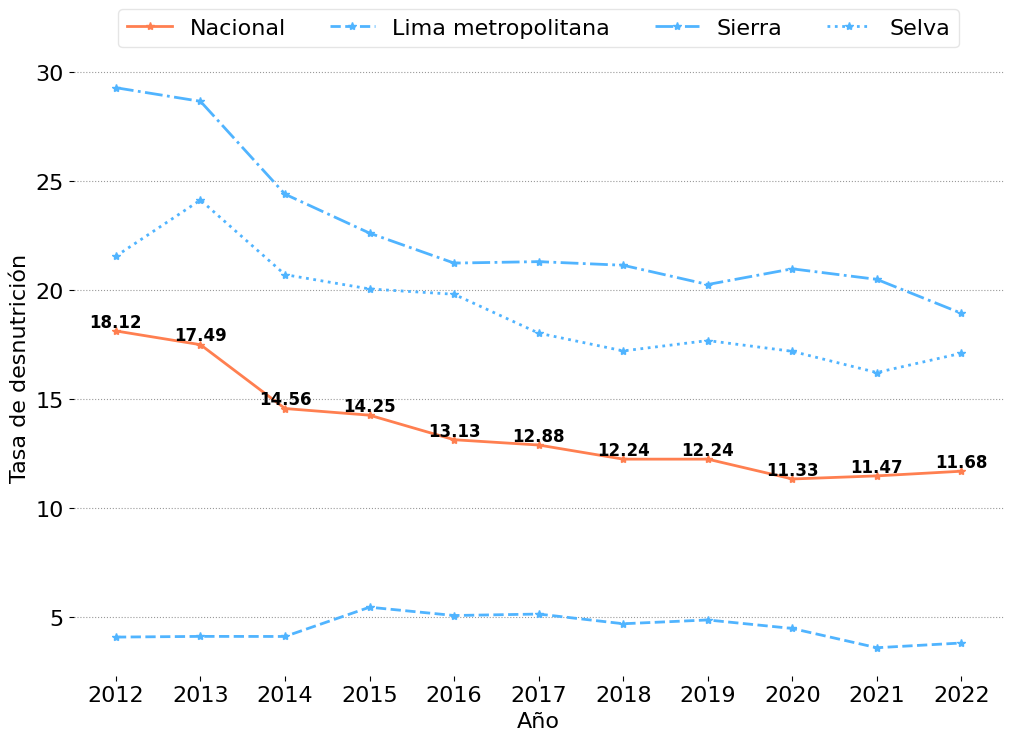

In [ ]:

fig,ax1 = plt.subplots(1,figsize=(12,8))

ax1.plot(desnut.DC, linewidth = 2, color = '#FF7F50', marker='*' )
ax1.plot( region[region.SHREGION=='lima']['desn_bin'],color = '#50B4FF', marker='*' , linestyle = '--', linewidth = 2)
ax1.plot( region[region.SHREGION=='sierra']['desn_bin'],color = '#50B4FF', marker='*' ,linestyle = '-.', linewidth = 2)
ax1.plot( region[region.SHREGION=='selva']['desn_bin'],color = '#50B4FF', marker='*' ,linestyle = ':', linewidth = 2)



ax1.grid(linestyle=':',alpha=0.8, color='gray',axis='y')

for x, y in zip(desnut.index, desnut.DC):
    plt.text(x, y, round(y,2), ha='center', va='bottom', fontsize=12, fontweight='bold')

legend = ax1.legend(loc='best')
legend.get_frame().set_alpha(0.5)

ftsz = 16
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

for ii in ['right', 'top', 'left','bottom' ]:
  ax1.spines[ii].set_visible(False)

ax1.set_ylabel("Tasa de desnutrición")
ax1.set_xlabel("Año")

years = 1
ax1.set_xticks(anemia.index[::years])



legend = ['Nacional', 'Lima metropolitana', 'Sierra', 'Selva']



legend = ax1.legend( legend, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=4, fontsize=ftsz)
legend.get_frame().set_alpha(0.5)


fig.savefig("desnut_anios_reg.png", bbox_inches='tight',transparent=True)
plt.show()


### Hacer un grafico de costa, sierra y selva.
## Tambien mostrar la tasa a nivel nacional.

In [ ]:
region = pd.concat(Store_regi_anem,axis=0).reset_index().set_index('year')
region['anem_bin'] = region['anem_bin']*100

## Tasa de anemia por region

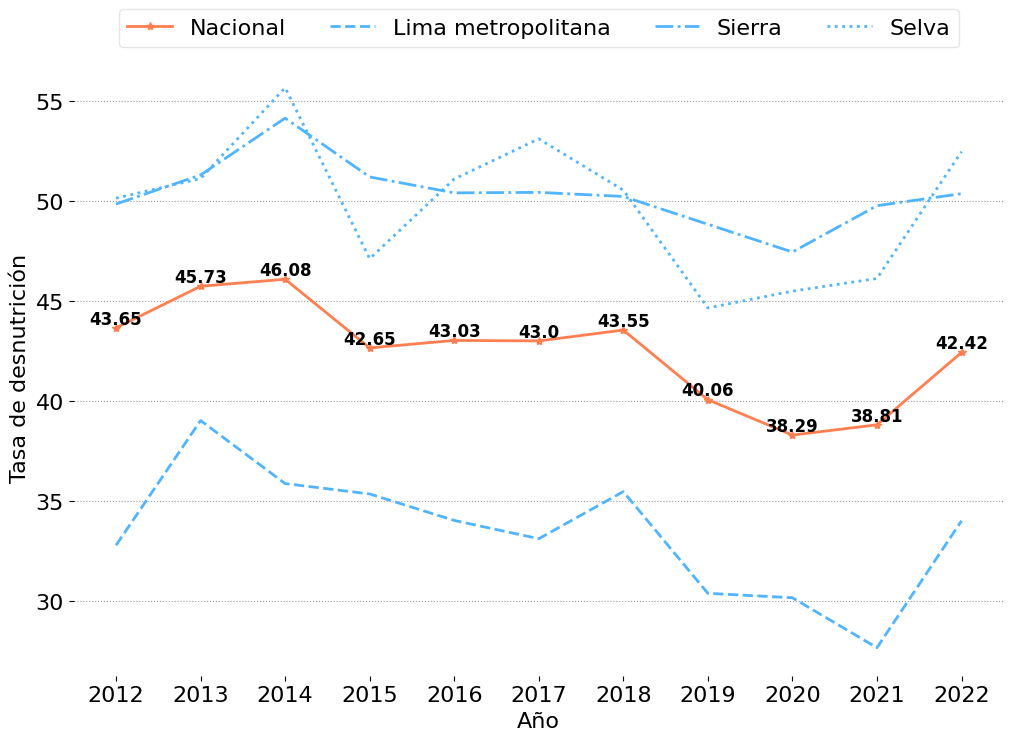

In [ ]:

fig,ax1 = plt.subplots(1,figsize=(12,8))

ax1.plot(anemia.Anemia, linewidth = 2, color = '#FF7F50', marker='*' )
ax1.plot( region[region.SHREGION=='lima']['anem_bin'],color = '#50B4FF', linestyle = '--', linewidth = 2)
ax1.plot( region[region.SHREGION=='sierra']['anem_bin'],color = '#50B4FF', linestyle = '-.', linewidth = 2)
ax1.plot( region[region.SHREGION=='selva']['anem_bin'],color = '#50B4FF', linestyle = ':', linewidth = 2)


ax1.grid(linestyle=':',alpha=0.8, color='gray',axis='y')

for x, y in zip(anemia.index, anemia.Anemia):
    plt.text(x, y, round(y,2), ha='center', va='bottom', fontsize=12, fontweight='bold')

legend = ax1.legend(loc='best')
legend.get_frame().set_alpha(0.5)

ftsz = 16
for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels() +
             ax1.legend().get_texts()):
    item.set_fontsize(ftsz)

for ii in ['right', 'top', 'left','bottom' ]:
  ax1.spines[ii].set_visible(False)

ax1.set_ylabel("Tasa de desnutrición")
ax1.set_xlabel("Año")

years = 1
ax1.set_xticks(anemia.index[::years])


legend = ['Nacional', 'Lima metropolitana', 'Sierra', 'Selva']


legend = ax1.legend( legend, bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=4, fontsize=ftsz)
legend.get_frame().set_alpha(0.5)


fig.savefig("anem_anios_reg.png", bbox_inches='tight',transparent=True)
plt.show()


### Hacer un grafico de costa, sierra y selva.
## Tambien mostrar la tasa a nivel nacional.

0-1-2-3-4-

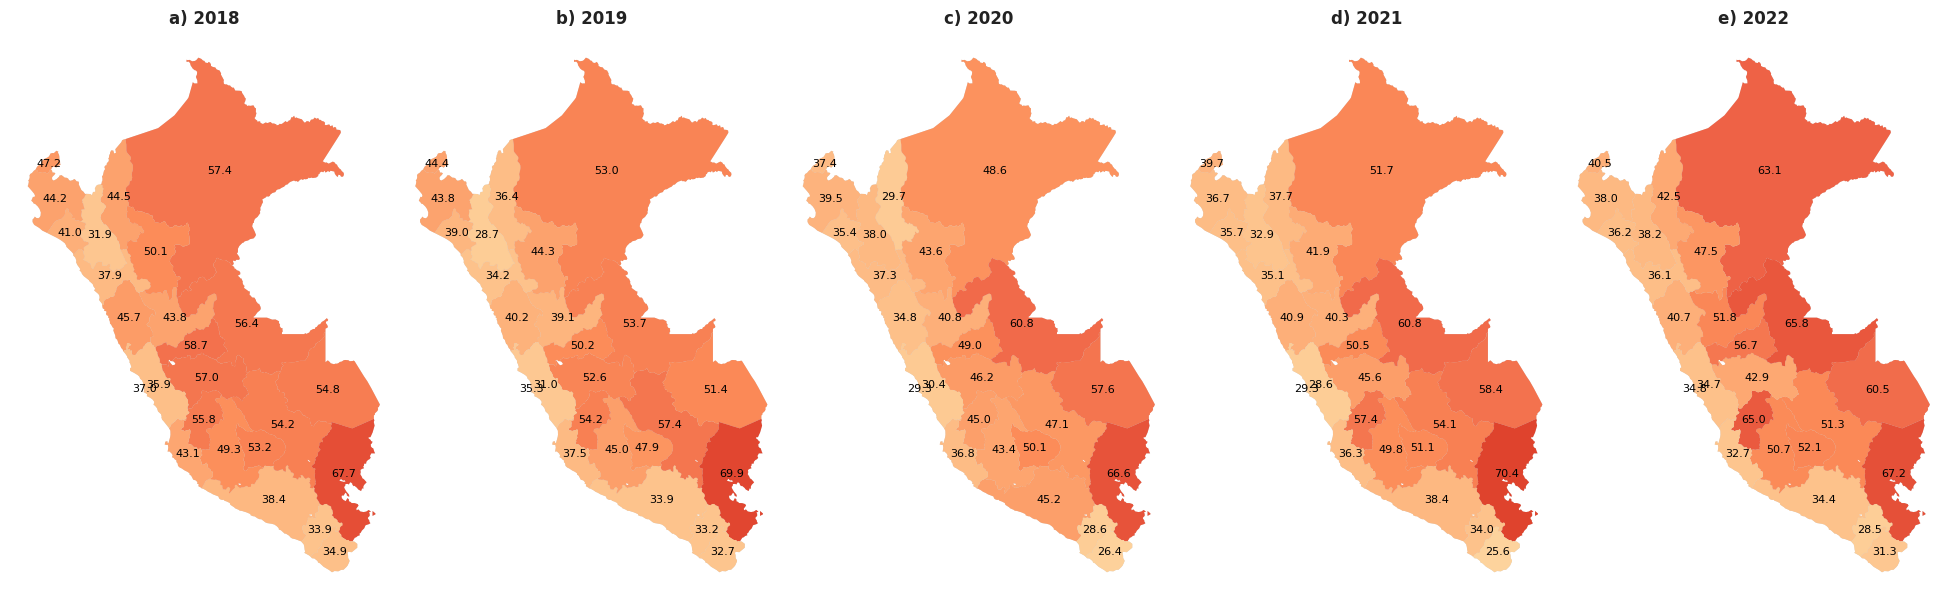

In [ ]:

num_year = list(map_dep.year.value_counts().index)
items = [chr(value) for value in range(97, 97+len(num_year))]
iyear = 2018

# Definir el tamaño de la figura y la estructura de la cuadrícula
fig = plt.figure(figsize=(25, 13))
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 1])

# Crear una lista de mapas de colores para cada año
cmaps = [plt.cm.OrRd for _ in range(len(num_year))]

for ii in range(len(num_year)):
    print(ii, end='-')
    ax = fig.add_subplot(gs[0, ii])  # Obtener el subplot correspondiente a la posición actual
    df_year = map_dep[map_dep.year == iyear]
    mapa_coordinates_dep.plot(ax=ax, alpha=0.35, color="grey")
    df_year.plot(column='anem_bin', categorical=False, vmin=0, vmax=100, ax=ax, cmap=cmaps[ii],
                 legend=False)
    ax.axis('off')
    ax.set_title(items[ii] + ') ' + str(iyear), fontsize=12, fontname='sans-serif', fontweight='bold', color='#222222')

    # Agregar etiquetas a cada polígono
    for x, y, label in zip(df_year.geometry.centroid.x, df_year.geometry.centroid.y, df_year['anem_bin']):
      ax.text(x, y, round(label,1), fontsize=8, ha='center', va='center', color='black')

    iyear += 1

# Ajustar el tamaño de cada subplot
gs.update(wspace=0, hspace=0)


#fig.savefig("pobreza_deps_anios.pdf", bbox_inches='tight')
#fig.savefig("pobreza_deps_anios.png", bbox_inches='tight')

plt.show()
